# Preparación, Análisis y Modelamiento de Datos

##### Luengas R. Fabian

Los datos que se presentan son los resultados que se originaron de las prueba saber pro competencias genéricas en el año 2019 segundo periodo y han sido recuperados desde datos.abiertos.gov.co, es de aclarar que los datos han sido filtrados para solo la ciudad de Bogotá.

Este trabajo busca ajustar el mejor modelo de pronóstico de la variable que representa el puntaje obtenido por el estudiante en las pruebas, las variables predictoras que se seleccionarán son información demográfica que el mismo estudiante registro al momento de su inscripción.

Con el fin de encontrar el mejor rendimiento del modelo, las variables regresoras deben pasar por un proceso de alistamiento y transformación, así se mejorará la interpretación de los algoritmos de machine learning y el pronóstico será acertado al momento de que el modelo se enfrente a datos nuevos. Inicialmente se realiza un análisis descriptivo de las variables predictoras con el fin de identificar problemas latentes en su distribución y/o tipos de datos.

In [1]:
# Tratamiento
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
import seaborn as sns
pd.options.display.float_format='{:.4f}'.format
style.use('ggplot') or plt.style.use('ggplot')

# Analisis
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.tree import export_text
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.tree import export_graphviz
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA

# System
from io import StringIO
from IPython.display import Image
import pydotplus
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Carga del Dataset
df = pd.read_csv('gener2019Bog.csv')

## Limpieza de Datos.

#### Revisión Variables Dataset
A continuación se realiza un análisis general a todas las variables del dataset con el fin de determinar su aporte y participación en los demás análisis que le preceda a este. Inicialmente, Se puede apreciar un total de 106 variables, entre ellas se encuentran posibles variables categóricas y numéricas, por tanto, identificar y separar las variables para su respectivo análisis es un punto importante a desarrollar en este análisis, en primera instancia, se le dará tratamiento a las variables que transmiten ruido en el dataset y no aportan información relevante.

In [3]:
# Definición de variables Nulas.
variables_nulas = []
for var in df.columns:
    if df[var].dtype == 'object':
        if df[var].nunique() == 1:
            variables_nulas.append(var)

# Eliminar Variables Nulas
df.drop(variables_nulas,axis=1, inplace=True)
df.drop(['ESTU_FECHANACIMIENTO'],axis=1,inplace=True)

# Eliminar Variables Numericas.
df.drop(['Unnamed: 0','ESTU_CODDANE_COLE_TERMINO'],axis=1,inplace=True)

# Filtrar variables Numericas
variables_num = []
for var in df.columns:
    if df[var].dtype == 'int64' or df[var].dtype == 'float64':
        variables_num.append(var)
        
# Eliminar Variables con valores nulos y eliminar registros con nulos.

def elim_null(df,porcj):
    nulos = pd.DataFrame({'Porcentaje':df.isna().sum(axis=0)/len(df)*100})
    index = nulos.index
    for i in index:
        valor = nulos.loc[i,'Porcentaje']
        if valor > porcj:
            df.drop([i],axis=1,inplace=True)
            

# Eliminar variables con mas del 15% de valores nulos
elim_null(df,15.0)

# Filtrar variables Categoricas
variables_cat = []
for var in df.columns:
    if df[var].dtype == 'object':
        df[var] = df[var].astype('category')
        variables_cat.append(var)

# Eliminar registros con nulos
df.dropna(inplace=True)

In [42]:
# Selección de variables categoricas
df_catg = pd.DataFrame(df[variables_cat].nunique()).sort_values(by=0,ascending = False ).reset_index().rename(columns={0:'Cantidad'})
filtro = (df_catg.Cantidad <= 8)
df_catg = df_catg[filtro]
X = list(df_catg['index'])

## Transformación de los Datos.

El tratamiento y transformación de los datos permiten mejorar el rendimiento de los algoritmos de clasificación y regresión, en la siguiente sección se identifica dos formas de transformar las variables categóricas y codificarlas. La primera forma transforma en variables booleanas cada una de las categorías contenidas en el dataset y la segunda forma codifica y etiqueta las categorías de la variable categórica. 

Con esta transformación, el algoritmo interpreta mejor las características y patrones de los datos, por consiguiente se ajusta mejor un modelo de pronóstico. Con el fin de no aumentar la dimensionalidad del dataset, se decide codificar y etiquetar los datos en la misma variable, es decir se descarta la creación de variables dummies que extenderían las dimensiones del dataset, así eventualmente se evita mejorar el rendimiento en el procesamiento del mismo modelo.

In [46]:
# Reducir los nombres de las categorias para mejorar el rendimiento
df.ESTU_VALORMATRICULAUNIVERSIDAD.replace({
    'Entre 1 millón y menos de 2.5 millones': '1m y 2.5m',
    'Entre 2.5 millones y menos de 4 millones': '2.5m y 4m',
    'Más de 7 millones': '7 m',
    'Entre 4 millones y menos de 5.5 millones': '4m y 5.5m',
    'Entre 5.5 millones y menos de 7 millones': '5.5m y 7m',
    'Entre 500 mil y menos de 1 millón':'500 mil y 1m',
    'No pagó matrícula':'No pago'
},inplace=True)

df.ESTU_HORASSEMANATRABAJA.replace({'Más de 30 horas': '30+',
                                   'Entre 11 y 20 horas':'11h y 20h',
                                   '0':'0h',
                                   'Entre 21 y 30 horas':'21h y 30h',
                                   'Menos de 10 horas':'10-'}, inplace=True)


# Listando las variables regresoras para el modelo
select = list(['ESTU_GENERO','ESTU_PAGOMATRICULAPADRES',
               'ESTU_VALORMATRICULAUNIVERSIDAD','ESTU_SEMESTRECURSA',
               'FAMI_ESTRATOVIVIENDA','FAMI_TIENEINTERNET','FAMI_TIENECONSOLAVIDEOJUEGOS',
               'FAMI_CUANTOSCOMPARTEBAÑO','ESTU_HORASSEMANATRABAJA','ESTU_METODO_PRGM',
              'INST_CARACTER_ACADEMICO'])


# One Hot Encoding.
def one_hot_encoding(df,select):
    filter_x = []
    for i in regr_vars:
        categorias = df[i].value_counts().index
        for k in categorias:
            name = 'is-'+str(i)+'-'+str(k)
            df[name] = np.where(df[i]==k,1,0)
            filter_x.append(name)
        df = df.drop([i],axis=1)
    return df,filter_x

# Label Encoder.

def label_encoder(df,select):
    df_f = df.copy(deep=True)
    encoder = LabelEncoder()
    for col in select:
        df_f[col] = encoder.fit_transform(df_f[col])
    return df_f

# Construcción Base Final

def build(df,select,y):
    df_final = df[select]
    df_final[y] = df[y]
    return df_final

df_encode = label_encoder(df,select)
df_final = build(df_encode,select,'PUNT_GLOBAL')

In [69]:
from sklearn.linear_model import LinearRegression
y = 'PUNT_GLOBAL'
df_temp = pd.get_dummies(df[X])
select = list(df_temp.columns)
df_temp1 = df.merge(df_temp,left_index=True,right_index=True)

df_final1 = build(df_temp1,select,'PUNT_GLOBAL')

y_1 = df_final1['PUNT_GLOBAL']
X_1 = df_final1.drop(['PUNT_GLOBAL'],axis=1)


X_train,X_test,y_train,y_test = train_test_split(X_1,y_1,test_size=0.15,random_state=1)


modelo_p = Pipeline([('scale', StandardScaler()),
                 ('pca', PCA(n_components=10)),
                 ('model', LinearRegression())])

modelo_p1 = Pipeline([('scale', StandardScaler()),
                 ('pca', PCA(n_components=10)),
                 ('model', DecisionTreeRegressor(max_depth=3,random_state = 12))])

modelo_p1.fit(X_train,y_train)

Pipeline(steps=[('scale', StandardScaler()), ('pca', PCA(n_components=10)),
                ('model', DecisionTreeRegressor(max_depth=3, random_state=12))])

In [70]:
modelo_p1.score(X_test,y_test)

0.36420408219142064

## Análisis Descriptivo de las Variables

El análisis descriptivo nos brinda perspectiva de la distribución y comportamiento de las categorías frente al puntaje obtenido por el estudiante en las pruebas, a continuación se realiza un análisis de confrontación con la variable objetivo con cada una de las categorías utilizadas para el ajuste del modelo de pronóstico.

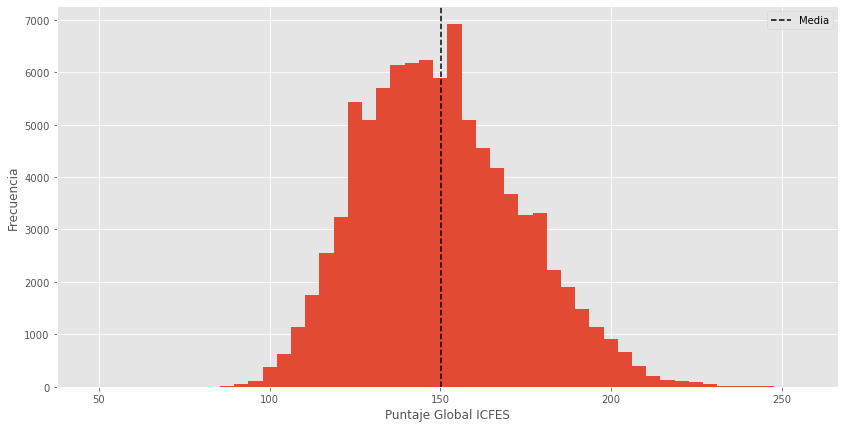

In [14]:
mu = df['PUNT_GLOBAL'].mean()
sigma = np.std(df['PUNT_GLOBAL'])
n_bins = 50

fig,ax = plt.subplots(figsize=(14,7))

n,bins,patches = ax.hist(df['PUNT_GLOBAL'],n_bins,density=False)
ax.set_xlabel('Puntaje Global ICFES')
ax.set_ylabel('Frecuencia')
ax.axvline(mu,linestyle='--',label='Media',color='k')
ax.legend()
plt.show()

La variable **punteo global** presenta una distribución normal, con media de 149 puntos y una desviación estandar de 24 puntos, se evidencia una ligera acumulación de valores atipicos en la cola superior de la distribución.

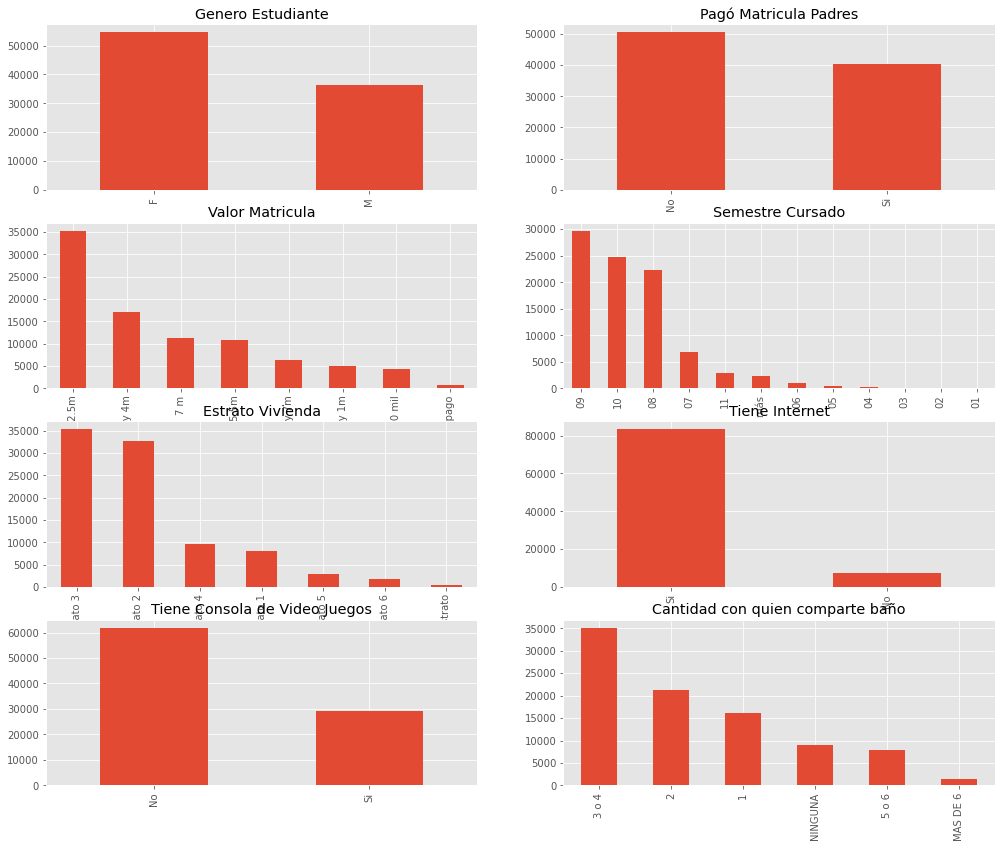

In [12]:
fig,ax = plt.subplots(4,2, figsize= (17,14))

df['ESTU_GENERO'].value_counts().plot.bar(ax = ax[0,0],title = 'Genero Estudiante')
df['ESTU_PAGOMATRICULAPADRES'].value_counts().plot.bar(ax = ax[0,1],title = 'Pagó Matricula Padres')
df['ESTU_VALORMATRICULAUNIVERSIDAD'].value_counts().plot.bar(ax = ax[1,0],title = 'Valor Matricula')
df['ESTU_SEMESTRECURSA'].value_counts().plot.bar(ax = ax[1,1],title = 'Semestre Cursado')
df['FAMI_ESTRATOVIVIENDA'].value_counts().plot.bar(ax = ax[2,0],title = 'Estrato Vivienda')
df['FAMI_TIENEINTERNET'].value_counts().plot.bar(ax = ax[2,1],title = 'Tiene Internet')
df['FAMI_TIENECONSOLAVIDEOJUEGOS'].value_counts().plot.bar(ax = ax[3,0],title = 'Tiene Consola de Video Juegos')
df['FAMI_CUANTOSCOMPARTEBAÑO'].value_counts().plot.bar(ax = ax[3,1],title = 'Cantidad con quien comparte baño')
plt.show()

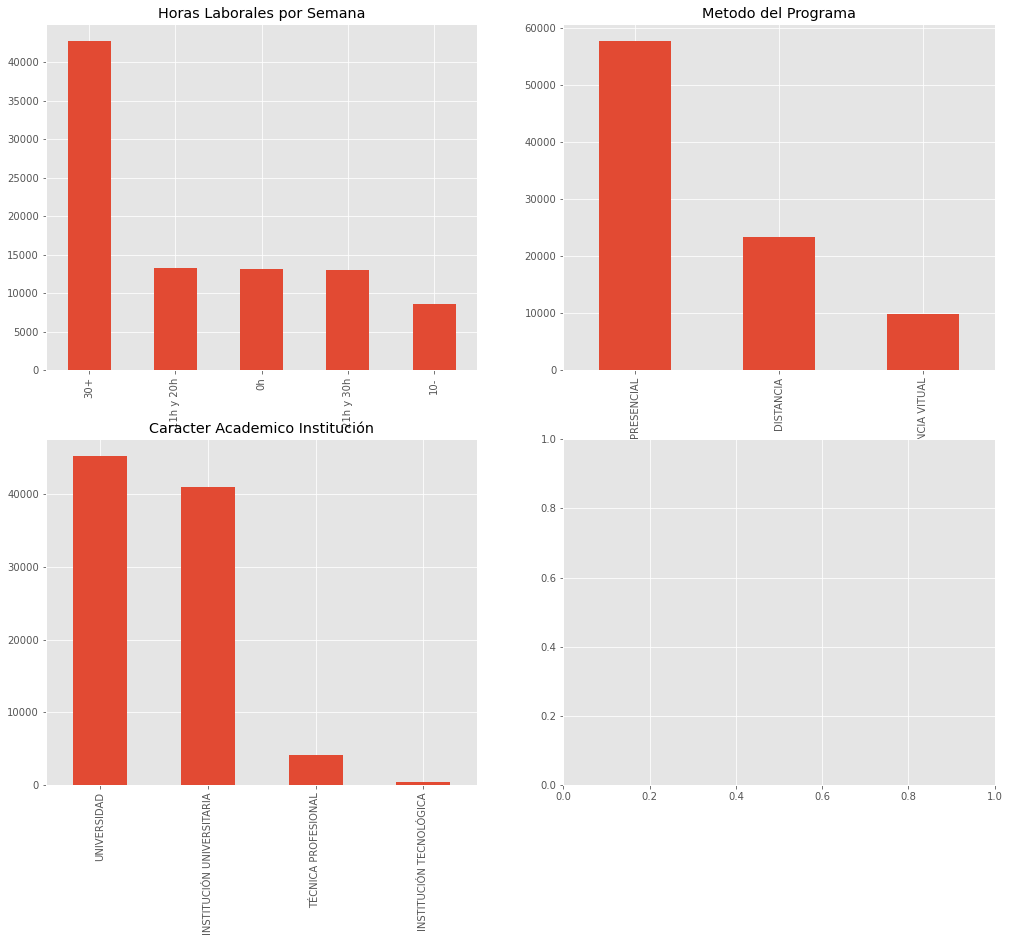

In [11]:
fig,ax = plt.subplots(2,2, figsize= (17,14))

df['ESTU_HORASSEMANATRABAJA'].value_counts().plot.bar(ax = ax[0,0],title = 'Horas Laborales por Semana')
df['ESTU_METODO_PRGM'].value_counts().plot.bar(ax = ax[0,1],title = 'Metodo del Programa')
df['INST_CARACTER_ACADEMICO'].value_counts().plot.bar(ax = ax[1,0],title = 'Caracter Academico Institución')
plt.show()

En la sección anterior se evidencian los graficos de frecuencia de cada unas de las variables categoricas utilizadas en el ajuste del modelo de predicción, a continución se presentan las siguientes conclusiones.

- Es evidente que en las clases de las variables *Metodo del programa*, *Horas Laborales*, *Consola de video juegos*, *internet* y *Valor de la matricula del programa* se presenta un claro desbalanceo.
- Una de las soluciones para este desbalanceo es la metodología de submuestreo aleatorio, limitando la clase dominante a la cantidad promedio de las demas clases. 
- Uno de los inconvenientes que se presentaron en el proceso de balanceo de clases, es la cantidad de datos que se pierden en el proceso, al existir un sesgo amplio entre las clases dominantes y las mas debiles se encuentra una cantidad considerable de datos perdidos, este proceso puede ocasionar un problema de predicción de fuga de etiquetas.

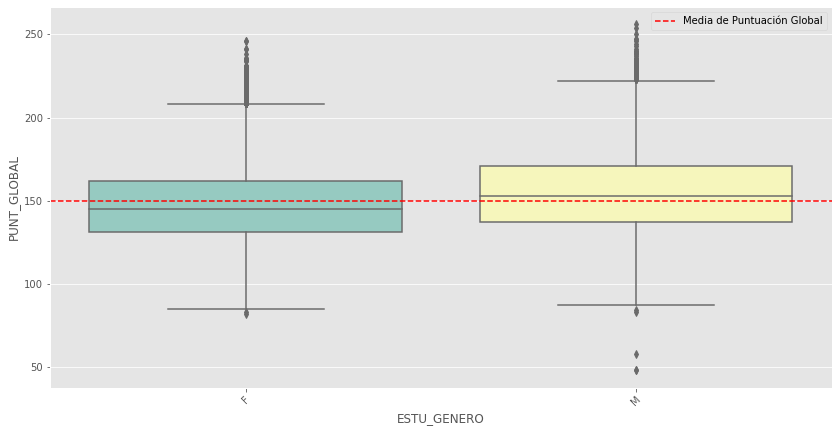

In [15]:
fig,ax = plt.subplots(figsize=(14,7))
sns.boxplot(x=df['ESTU_GENERO'],y=df['PUNT_GLOBAL'],palette='Set3')
ax.axhline(mu,linestyle='--',label='Media de Puntuación Global',color='r')
ax.legend()
plt.xticks(rotation=45)
plt.show()

- La distribución de los puntajes de la prueba entre el genero masculino y femenino no presentan una marcada diferencia, aunque la condensación de los puntajes del genero masculino se ubica pocos puntos por encima.

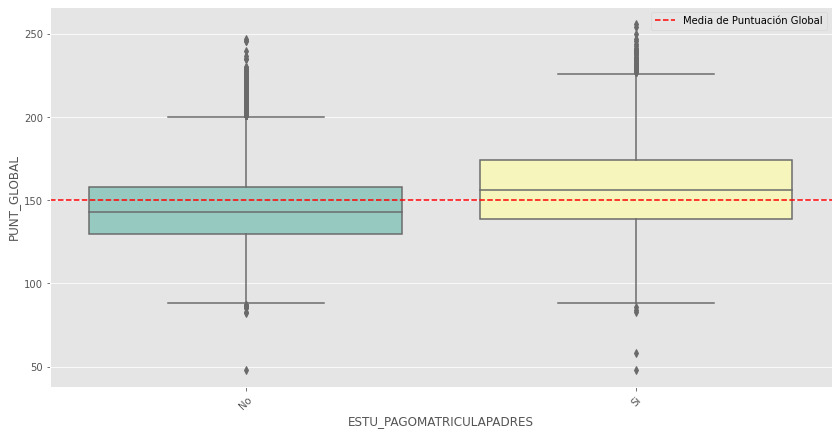

In [17]:
fig,ax = plt.subplots(figsize=(14,7))
sns.boxplot(x=df['ESTU_PAGOMATRICULAPADRES'],y=df['PUNT_GLOBAL'],palette='Set3')
ax.axhline(mu,linestyle='--',label='Media de Puntuación Global',color='r')
ax.legend()
plt.xticks(rotation=45)
plt.show()

- Para estas categorias se empieza a evidenciar una diferencia marcada entre los estudiantes que sus padres pagaron la matricula del programa y los que no, la evidencia indica que el puntaje de los estudiantes que sus padres pagaron la matricula presentan una distribución de sus datos con una mediana mayor a la media poblacional.

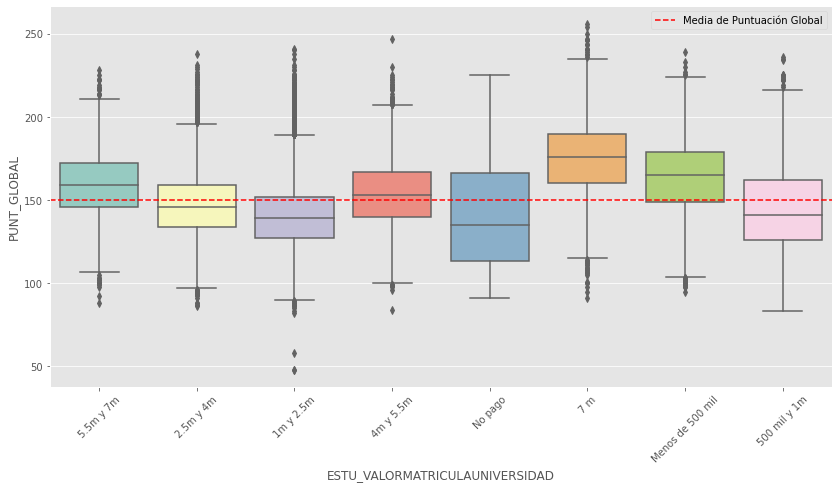

In [18]:
fig,ax = plt.subplots(figsize=(14,7))
sns.boxplot(x=df['ESTU_VALORMATRICULAUNIVERSIDAD'],y=df['PUNT_GLOBAL'],palette='Set3')
ax.axhline(mu,linestyle='--',label='Media de Puntuación Global',color='r')
ax.legend()
plt.xticks(rotation=45)
plt.show()

- La distribución de los datos para los estudiantes que pagan una matricula de valor superior presentan una notable mejoria en los resultados del examen, sin embargo, las personas que pagan un valor de matricula menor a 500 mil pesos presentan una distribución con valores en puntaje similares a las matriculas mas costosas.

# Modelos de Regresión.

### Decision Tree Regressor.

##### Partición de Datos en Entrenamiento y Testeo.

Se define una base de entrenamiento con la cual se ajustan los modelos de pronóstico.

In [15]:
X = df_final[select]
y = df_final['PUNT_GLOBAL']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.15,random_state=1)

##### Decision Tree Regressor Con Datos Estandarizados

La estandarización de los datos permite reducir la varianza entre datos con una escala de orden mayor en comparación a las demás variables del dataset, por consiguiente, se integra como primer paso en el proceso de modelamiento bajo la metodología de árbol de regresión.

El criterio para medir la calidad de cada división en el árbol, está definido por defecto como mse o error cuadrático medio, el cual representa el error entre las predicciones y los valores original al cuadrado, más adelante, en posteriores secciones se presentará el rmse o raíz del error cuadrático medio como criterio de evaluación de desempeño del modelo.

In [50]:
std = StandardScaler()

pipe = Pipeline([('std',std),
                ('tree',DecisionTreeRegressor(max_depth=3,random_state = 12))
                ])

pipe.fit(X_train,y_train)

y_pred = pipe.predict(X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f'El rmse del modelo es de {rmse} con un R2 ajustado de {pipe.score(X_test,y_test)}')

El rmse del modelo es de 18.781532192982553 con un R2 ajustado de 0.33585175862068084


Para este árbol de decisión se determina una profundidad máxima de 3 divisiones y el desempeño que arroja después de su ajuste es de 0.33, considerablemente bajo, ya que de esto podemos inferir que el modelo sólo explica el 33% de la varianza de la variable objetivo.

##### Decision Tree Regressor Con Datos sin Estandarizar

Con el fin de medir el impacto de la estandarización de las variables, se desarrolla el mismo modelo de la sección anterior quitando el primer paso de estandarización y se obtienen valores similares.

In [51]:
modelo_tree = DecisionTreeRegressor(
            max_depth = 3,
            random_state = 1
    )

modelo_tree.fit(X_train,y_train)

y_pred = modelo_tree.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )
var_ex = explained_variance_score(y_test,y_pred)

print(f' El rmse del modelo es de: {rmse} R2 cuadrado ajustado: {modelo_tree.score(X_test,y_test)}')

 El rmse del modelo es de: 18.781532192982553 R2 cuadrado ajustado: 0.33585175862068084


El valor que aporta la estandarización en este caso para un árbol de regresión es mínimo, ya que los valores en las variables regresoras no aportan mayor variabilidad o valores de alta varianza.

### Decision Tree Regressor, Pruning.

**Advertencia** *Si ya registra el valor resultante del código en la siguiente sección, no es necesario correr la siguiente linea de codigo, ya que dependiendo del rendimiento de la máquina puede llegar a tardar varios minutos*

El proceso de entrenamiento de un arboles de regresión se puede dividir en dos etapas:

- El espacio de los predictores se divide sucesivamente en regiones no solapantes es decir en nodos terminales, calificados como regiones.
- La predicción de la respuesta en cada región.

El objetivo de un árbol de regresión eficiente es encontrar una metodología que permita dividir estas regiones o identificar en que punto se introduce cada división, por lo general, manejado bajo un criterio de evaluación definido como la suma de los residuales del cuadrado, de tal manera que dicho valor es el menor valor posible.

Para ello es necesario ajustar los hiperparametros de tal forma que este criterio de evaluación es el menor valor posible, para esto existen varias técnicas conocidas, a continuación se presenta bajo validación cruzada.

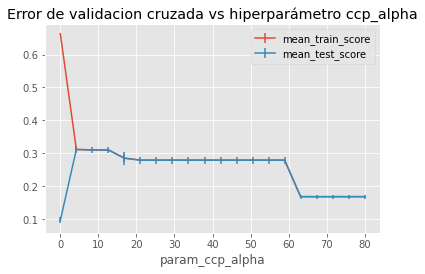

In [35]:
# Busqueda por validación cruzada

grid = GridSearchCV(
    # El arbol se crece lo maximo posible para despues hacer pruning
    estimator = DecisionTreeRegressor(
        max_depth = None,
        min_samples_split = 2,
        min_samples_leaf = 1,
        random_state = 1
        
        ),
    param_grid = {'ccp_alpha':np.linspace(0,80,20)},
    cv = 10,
    refit = True,
    return_train_score = True
)

grid.fit(X_train,y_train)

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");

In [36]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_final = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_final.get_depth()}")
print(f"Número de nodos terminales: {modelo_final.get_n_leaves()}")

Profundidad del árbol: 3
Número de nodos terminales: 4


La profundidad del árbol y la cantidad de nodos terminales se expresan en la sección de código anterior, dichos valores fueron encontrados después de la aplicación del algoritmo por búsqueda de validación cruzada.

In [37]:
y_predict = modelo_final.predict(X = X_test)

rmse_1 = mean_squared_error(
        y_true  = y_test,
        y_pred  = y_predict,
        squared = False
       )
var_ex_1 = explained_variance_score(y_test,y_predict)

print(f"El error (rmse) de test es: {rmse_1} y la varianza explicada es de: {var_ex_1}")

El error (rmse) de test es: 19.056176164857575 y la varianza explicada es de: 0.316318015168919


El algoritmo de validación cruzada no evidencia una mejora en el desempeño del modelo.

### Regularización; Elastic Net.

El proceso de regularización Elastic Net que se encuentra en la siguiente sección maneja un proceso de ajuste y modelado de regresión lineal, este tipo de regularización combina la regularización *lasso* y la regularización *ridge* y maneja un hiper parámetro denotado como alpha, este hiper parámetro se mide en una escala de **[0,1]** el cual se interpreta de la siguiente manera; entre más se acerque el hiper parámetro a cero, la regularización será en mayor proporción **ridge**, por otro lado, entre más se acerque a 1, la regularización será más **lasso**. 

El objetivo de la regularización es penalizar a los predictores que guarden correlación entre sí y/o no aporten significativamente al modelo, ocasionando problemas al modelo al momento de realizar pronósticos de valores jamás vistos en su entrenamiento.

Su proceso se resume en reducir de tal forma los parámetros de cada predictor de tal forma que no participe activamente en la decisión de pronóstico.

La siguiente regularización entrena un modelo con búsqueda por validación cruzada del valor óptimo de alpha.

In [17]:
modelo = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            normalize       = True,
            cv              = 10
         )

modelo.fit(X = X_train, y = y_train)

ElasticNetCV(alphas=array([1.00000000e-10, 1.16232247e-10, 1.35099352e-10, 1.57029012e-10,
       1.82518349e-10, 2.12145178e-10, 2.46581108e-10, 2.86606762e-10,
       3.33129479e-10, 3.87203878e-10, 4.50055768e-10, 5.23109931e-10,
       6.08022426e-10, 7.06718127e-10, 8.21434358e-10, 9.54771611e-10,
       1.10975250e-09, 1.28989026e-09, 1.49926843e-09, 1.74263339e-09,
       2.02550194e-09, 2.354286...
       5.73844165e+01, 6.66991966e+01, 7.75259749e+01, 9.01101825e+01,
       1.04737090e+02, 1.21738273e+02, 1.41499130e+02, 1.64467618e+02,
       1.91164408e+02, 2.22194686e+02, 2.58261876e+02, 3.00183581e+02,
       3.48910121e+02, 4.05546074e+02, 4.71375313e+02, 5.47890118e+02,
       6.36824994e+02, 7.40196000e+02, 8.60346442e+02, 1.00000000e+03]),
             cv=10, l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
             normalize=True)

In [65]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio 
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)

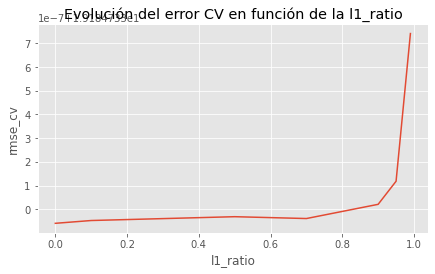

In [66]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [67]:
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 3.0367711180354604e-08
Mejor valor de l1_ratio encontrado: 0.0


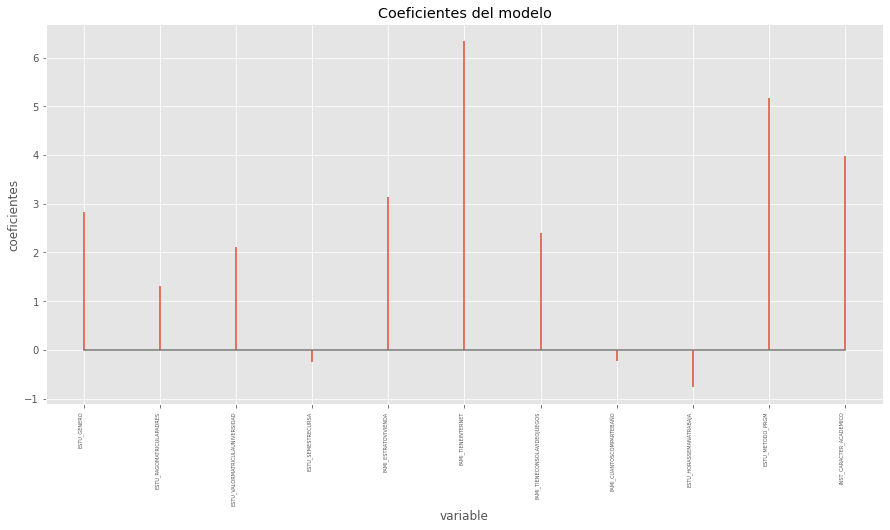

In [68]:
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(15, 7))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Los regresores más penalizados fueron **Semestre que cursa el estudiante** y **la cantidad de personas con quien comparte baños el estudiante** es posible inferir que esta última guarda correlación con la variable **Estrato de la vivienda** y es por esto que resulta ser penalizada por la regularización.

In [69]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
# Colapsa la dimensión en una sola
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_elastic} y el R2 es de {modelo.score(X_test,y_test)}")


El error (rmse) de test es: 19.07261725740953 y el R2 es de 0.3151056616398158


## Ensamble de Modelos.

### Bagging Regressor.

La capacidad predictiva de un solo árbol de decisión suele ser bastante limitada, por tanto, existe un método de ensamble de múltiples árboles de decisión entrenados en subconjuntos aleatorios del conjunto total de datos, esto permite obtener un conjunto variado de parámetros de los predictores los cuales aportan a la reducción de la varianza en el modelo.

In [45]:
bagging_model = BaggingRegressor(
    base_estimator = DecisionTreeRegressor(max_depth=3),
    random_state = 1, 
)

bagging_model.fit(X_train,y_train)

y_pred_bagging = bagging_model.predict(X_test)

rmse_bagging = mean_squared_error(
                y_true  = y_test,
                y_pred  = y_pred_bagging,
                squared = False
               )
print("")
print(f"El error (rmse) de test es: {rmse_bagging} y el R2 es de {bagging_model.score(X_test,y_test)}")


El error (rmse) de test es: 18.736329018590148 y el R2 es de 0.3390448400624969


### Ensamble: TreeRegressor

El proceso de ensamble de uno o más modelos es considerado como una metodología para mejorar la precisión y predicción del modelo, sin embargo, esta metodología requiere de más capacidad computacional, por consiguiente, la siguiente línea de código consume más recursos que las anteriormente aplicadas.

In [46]:
tre_reg = DecisionTreeRegressor(max_depth=3)
svr_reg = SVR(gamma='scale')

voting_reg = VotingRegressor(estimators= [('tree',tre_reg),
                                         ('svr',svr_reg)])

voting_reg.fit(X_train,y_train)
y_pred_en = voting_reg.predict(X_test)

rmse_ensamble = mean_squared_error(
                y_true  = y_test,
                y_pred  = y_pred_en,
                squared = False
               )


El error (rmse) de test es: 18.387968370758404


In [47]:
print(f"El error (rmse) de test es: {rmse_ensamble} y el R2 es de {voting_reg.score(X_test,y_test)}")

El error (rmse) de test es: 18.387968370758404 y el R2 es de 0.3633943554117456


Efectivamente el mejor rmse y R2 obtenido es el del modelo por ensamble de un árbol de regresión y un support vector regression a comparación de los demás modelos si obtiene una mejora, sin embargo su R2 sigue sin ser representativo para la predicción de los valores del dataset de testeo

## Conclusiones

- Para este conjunto de datos, el proceso de codificación de las variables categóricas para el ajuste de un modelo de regresión mejora su capacidad predictiva.
- la varianza en las variables predictoras para este conjunto de datos no representó problema al momento de estandarizar y/o normalizar sus valores.
- La capacidad predictiva de un modelo ajustado por ensamble de un árbol de regresión y una máquina de soporte vectorial de regresión es mejor que los demás tipos de modelos utilizados en este trabajo.
- El feature engineering es un factor importante al momento de generar variables regresoras que aporten más a la variabilidad de la variable objetivo.
- Se recomienda continuar con un proceso más profundo de feature engineering, se infiere que es una causa de el bajo rendimiento del modelo.